In [14]:
import lifelines
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(
    font_scale=1.5, 
    rc={'figure.figsize':(8,6)}
)
sns.set_style("whitegrid")
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve

Often thought of as a method to prevent overfitting, regularization can also be used to select the most important features from a model.

## What is regularization?

In any machine learning setting, you invariably find yourself with a set of parameters $\vec{\beta}$, which you wish to estimate from the data $\mathcal{D}$. A standard approach to estimating $\vec{\beta}$ is to write down a likelihood function $P(\mathcal{D}|\mathbf{\beta})$ and maximize the likelihood with respect to $\vec{\beta}$. This approach is called _maximum likelihood estimation_.

With regularization, we shift from a maximum _likelihood_ estimation to a maximum _a posterior_ estimation. In the Bayes' formulation, we have the posterior equation:

$$ P(\vec{\beta} | \mathcal{D}) = \frac{P(\mathcal{D}|\vec{\beta}) P(\vec{\beta})}{P(\mathcal{D})}, $$

where the term $P(\vec{\beta})$ is called the _prior_. It represents all pre-existing information obtained about $\vec{\beta}$, either through intuition or previous measurements. The term $P(\mathcal{D}|\mathbf{\beta})$ is the likelihood; for fixed $\mathcal{D}$, let's denote the likelihood as $L(\vec{\beta})$. 

To find the peak of the posterior distribution (i.e. the _maximum a posteriori_ estimate for $\vec{\beta}$), it is equivalent to minimize the following loss function:

$$ \text{loss} = -\log L(\vec{\beta}) - \log P(\vec{\beta}). $$

We can ignore the $P(\mathcal{D})$ term because it is constant with respect to $\vec{\beta}$. If we take a constant prior, $P(\vec{\beta}) = 1$, then the second term on the right hand side can be ignored and we have the standard maximum likelihood approach. 

However, there are very good reasons to enforce a non-constant prior on your parameters. For one, we almost always have useful prior knowledge. Consider a simple linear model $y \sim \vec{\beta}\cdot \vec{x}$. A standard first step in such an inference problem is to transform $\vec{x}$ and $y$ such that they have zero mean and unit variance. If we do that, then we can already with fairly high confidence rule out large regions of parameter space. For instance, taking $\beta_i = 100$ would mean that a unit change in $x_i$ would increase $y$ by 100 standard deviations. This behavior seems unlikely in almost any setting.

We can encode this belief in a prior. The prior tells the model to avoid considering regions of parameter space with $|\beta_i| \gtrsim 100$, unless there is _overwhelming_ evidence from the data (encoded in the likelihood). This can prevent you from falling into the trap of "overfitting" a model, i.e., seeing a pattern in the data that isn't really there. The model may say "hey you know if I set $\beta_2 = 100$, I can explain pretty much everything in the data." But the prior comes in and says "this conflicts with my expectations, I need more evidence of that before I can believe you."

The devil is, as always, in the details. There are multiple ways to encode the preference for smaller parameters mathematically and which approach you choose turns out to make a big difference in the kind of solutions you obtain. Here, I want to explore two different choices of prior beliefs, both consistent with the preference for smaller parameters, and illustrate how these choices impact the inferred model parameters.


# L1 and L2 regularization

Two very common forms of regularization are L1 and L2 regularization:

$$ \text{loss}_{L1} = -\log L(\vec{\beta}) + \alpha \sum_{i}|\beta_i| $$

$$\text{loss}_{L2} = -\log L(\vec{\beta}) + \alpha \sum_{i}\beta_i^2. $$

From above, we know that the regularization terms correspond to priors of the form $P_{L1}(\beta_i) \sim e^{-\alpha |\beta_i|}$ and $P_{L2}(\beta_i) \sim e^{-\alpha \beta_i^2}$. That is, L1 regularization corresponds an exponential prior, while L2 regularization corresponds to a Gaussian prior.

Gaussian priors are always so tempting. The world is Gaussian. We think in Gaussian. As a result, L2 regularization is by far the most common, which itself tends to reinforce the idea that you should always use it. But that little extra exponent "$^2$" makes a remarkable impact on the kind of results your parameter estimation gives, and it's very valuable to understand where an L1 regularization can be useful.

A classic example of the utility of L1 regularization is with redundant parameters, such as $y \sim \beta_1 x + \beta_2 x$. Here, the likelihood only depends on $\beta_1 + \beta_2$. On the face of it, this redundancy is not such a big deal. Your model probably will converge to a solution and you will be able to make predictions with your model. The problem comes in interpretation of the fitted parameters. What does $\beta_1$ mean? In this extreme example, it's clear that $\beta_1$ itself does not describe the effect of $x$ on $y$. In practice, we don't have literally identical features in our model and we aren't usually told that our input parameters contain redundant information. But wouldn't it be cool if the model would tell us?

That's one reason to use L1 regularization. The shape of the L1 prior is such that the model prefers to set parameters identically equal to zero. We can see this in the derivative of the prior with respect to $\beta_i$:

$$ \frac{\partial P_{L1}(\beta)}{\partial \beta} \sim \alpha $$

$$ \frac{\partial P_{L2}(\beta)}{\partial \beta} \sim 2 \alpha \beta $$

The important feature to note here is that for small values of $\beta$, the L2 regularization term has no effect. By contrast, L1 regularization has the same penalty for every unit increase in $\beta$. If $\beta_1 > \beta_2$ and increasing either would lead to the same increase in likelihood, L2 will prefer to increase $\beta_2$, whereas L1 will, regardless of the current parameter values, always choose to increase the parameter that benefits the likelihood the most. This will tend to lead to parameters that are more equally distributed in magnitude for L2 regularization compared to L1.

What often happens then, in practice, is that parameters that don't actually help that much converge towards identically zero with L1 regularization. L1 regularization can therefore be seen as a dimensionality reduction technique. It's useful when you have a lot of parameters and you know there is some redundancy in there and you want the model to just pick a handful of parameters to use.

# Regularization in action

To see how L1 and L2 regularization impacts parameter estimation, let's experiment with a toy classification problem using logistic regression. We simulate a dataset with 100 features, only 20 of which are informative. The remaining 80 are just noise. In the figure below, I've shown just four of the 100 variables, two informative and two non-informative.


In [15]:
#| include: true
from sklearn.datasets import make_classification

n_samples = 10000
n_features = 100
X, y = make_classification(
    n_samples, 
    n_features, 
    n_informative=20, 
    n_redundant=0, 
    n_repeated=0, 
    n_classes=2,
    class_sep=1,
    shuffle=False,
    random_state=123)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

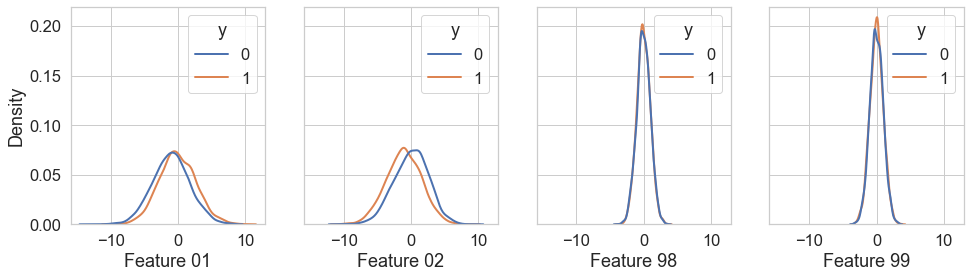

In [16]:
#| label: fig-input-distributions
#| fig-cap: "One dimensional marginal distributions for a few 
#|     varaibles in the simulation."
#| include: true
#| echo: false

fig, ax = plt.subplots(
    nrows=1, 
    ncols=4,
    sharey=True, 
    sharex=True,
    figsize=(16,4))

df_train = pd.DataFrame.from_records(
    X_train,
    columns=[f'Feature {j:02d}' for j in range(X_train.shape[1])]
)
df_train.loc[:, 'y'] = y_train

for j, feat in enumerate([1, 2, 98, 99]):
    sns.kdeplot(
        x=f'Feature {feat:02d}',
        hue='y',
        linewidth=2,
        data=df_train,
        ax=ax[j])


Now let's see what happens when we train a logistic regression with three different kinds of regularization terms: (1) no regularization, (2) L1 and (3) L2. Below, I show the ROC curve for each classifier on the hold-out test set. What we see is that three classifiers are indistinguishable in terms of their predictive capability. This result might tempt you to think that regularization doesn't matter for your problem. But that is wrong!

In [17]:
#| include: true
from sklearn.linear_model import LogisticRegression

clf_nopenalty = LogisticRegression(
    penalty=None, 
    max_iter=10000, 
    solver='saga')
clf_nopenalty.fit(X_train, y_train)

clf_l1 = LogisticRegression(
    penalty='l1', 
    max_iter=10000, 
    solver='saga', 
    C=0.01)
clf_l1.fit(X_train, y_train)

clf_l2 = LogisticRegression(
    penalty='l2', 
    max_iter=10000,
    solver='saga', 
    C=0.001)
clf_l2.fit(X_train, y_train)

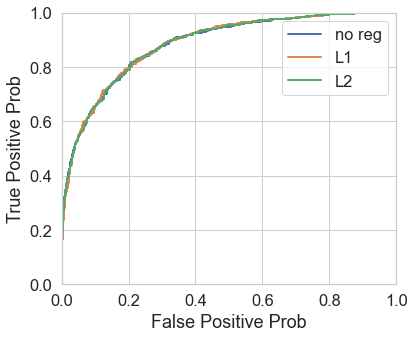

In [21]:
#| label: fig-roc
#| fig-cap: "ROC for each of three classifiers trained with 
#|     different regularization options."
#| include: true
#| echo: false

from sklearn.metrics import roc_curve, roc_auc_score

y_pred = clf_nopenalty.predict_proba(X_test)[:, 1]
fpr_nopenalty, tpr_nopenalty, _ = roc_curve(y_test, y_pred)

y_pred = clf_l1.predict_proba(X_test)[:, 1]
fpr_l1, tpr_l1, _ = roc_curve(y_test, y_pred)

y_pred = clf_l2.predict_proba(X_test)[:, 1]
fpr_l2, tpr_l2, _ = roc_curve(y_test, y_pred)

fig, ax = plt.subplots(
    nrows=1, 
    ncols=1,
    sharey=True, 
    sharex=True,
    figsize=(6,5))
ax.plot(fpr_nopenalty, tpr_nopenalty, label='no reg', linewidth=2)
ax.plot(fpr_l1, tpr_l1, label='L1', linewidth=2)
ax.plot(fpr_l2, tpr_l2, label='L2', linewidth=2)
plt.xlim([0,1])
plt.ylim([0,1])
plt.xlabel('False Positive Prob')
plt.ylabel('True Positive Prob')
_ = plt.legend()

The classifiers look _very_ different when we look at the resulting coefficients! Compared to no regularization, the L2 regularized classifiers returns all-around smaller coefficients. But the L1 regularized classifier does something even more remarkable. It returns exactly 19 non-zero coefficients! It was able to detect and remove most of the noise from the problem.

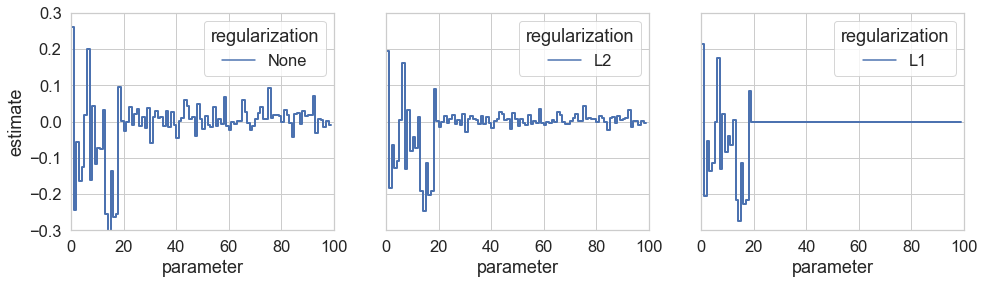

In [31]:
#| label: fig-main
#| class: preview-image
#| fig-cap: "Returned coefficients for each of the three classifiers. 
#|     By the problem setup, only the first 20 parameters are expected to 
#|     contribute to the signal. Only the L1 regularized model is able to 
#|     learn that information."
#| include: true
#| echo: false
fig, ax = plt.subplots(
    nrows=1, 
    ncols=3,
    sharey=True, 
    sharex=True,
    figsize=(16,4))

df_nopenalty = pd.DataFrame.from_dict({
    'parameter':list(range(n_features)),
#     'estimate':sorted(clf_nopenalty.coef_[0]),
    'estimate':clf_nopenalty.coef_[0],
    'regularization': 'None'
})
df_l1 = pd.DataFrame.from_dict({
    'parameter':list(range(n_features)),
#     'estimate':sorted(clf_l1.coef_[0]),
    'estimate':clf_l1.coef_[0],
    'regularization': 'L1'
})
df_l2 = pd.DataFrame.from_dict({
    'parameter':list(range(n_features)),
#     'estimate':sorted(clf_l2.coef_[0]),
    'estimate':clf_l2.coef_[0],
    'regularization': 'L2'
})

# sns.barplot(data=df, x='parameter', y='estimate', linewidth=0, color='k')
sns.lineplot(
    data=df_nopenalty,
    x='parameter', 
    y='estimate', 
    linewidth=2, 
    hue='regularization',
    drawstyle='steps-pre',
    ax=ax[0])

sns.lineplot(
    data=df_l2,
    x='parameter', 
    y='estimate', 
    linewidth=2, 
    hue='regularization',
    drawstyle='steps-pre',
    ax=ax[1])

sns.lineplot(
    data=df_l1,
    x='parameter', 
    y='estimate', 
    linewidth=2, 
    hue='regularization',
    drawstyle='steps-pre',
    ax=ax[2])
plt.xlim([0, n_features])
plt.ylim([-0.3, 0.3])
_ = plt.grid(True)
plt.show()

I've cheated here a little bit, however. I knew I wanted 20 parameters and so I picked a regularization coefficient (above called $\alpha$) to give me roughly the right number of non-zero coefficients. How could we figure out the right regularization strength in practice?

One idea is to try a number of different regularization strengths. For each regularization strength, train a model and compute an out-of-sample metric (e.g. AUC). Then make a curve showing out-of-sample performance versus the number of non-zero coefficients, as shown below. 

In [29]:
Cs = np.logspace(-4, 1, 25)
rocs = []
n_feats = []
for C in Cs:
    clf2 = LogisticRegression(penalty='l1', max_iter=10000, solver='saga', C=C)
    clf2.fit(X_train, y_train)
    y_pred = clf2.predict_proba(X_test)[:, 1]
    roc = roc_auc_score(y_test, y_pred)
    n_feat = len( clf2.coef_[0][clf2.coef_[0] != 0])
    rocs.append(roc)
    n_feats.append(n_feat)

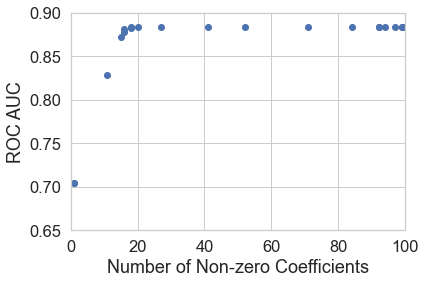

In [30]:
#| label: fig-elbow
#| fig-cap: "Performance versus number of features in model"
#| include: true
#| echo: false

plt.scatter(n_feats, rocs)
plt.xlim([0, 100])
plt.ylim([0.65, 0.9])
plt.xlabel('Number of Non-zero Coefficients')
_ = plt.ylabel('ROC AUC')

The plot seems to suggest that using fewer than 20 features is detrimental to performance and that using significantly more than 20 does not help very much. Thus, we are able to extract, more or less, the correct number of features to use in our model.

# Conclusion

Regularization is a common technique to incorporate prior knowledge into making inferences from data. Priors that express a preference for smaller model parameters can help prevent overfitting, but there are multiple ways to express this preference mathematically. Two common ways are L1 and L2 regularization and these can be expressed in words as follows:

* L1 regularization: I believe my parameters are small and some of my parameters are not needed at all.
* L2 regularization: I believe my parameters are small and should be distributed as uniformly as possible.

Using L1 regularization, one can extract the most relevant features for a model. This can be particularly desirable when explainability is important for your application.